In [175]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as wdg
import time
import numpy as np
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
%matplotlib inline  

In [176]:
Stroke_df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [177]:
Stroke_df = Stroke_df.fillna(Stroke_df.mean())

In [178]:
#Transforme the classification data into binary
Stroke_df1 = pd.get_dummies(Stroke_df) 

In [179]:
#Delete id column 
Stroke_df1 = Stroke_df1.drop("id", axis=1)

In [180]:
#Correlation Heatmap
corr = Stroke_df1.corr()

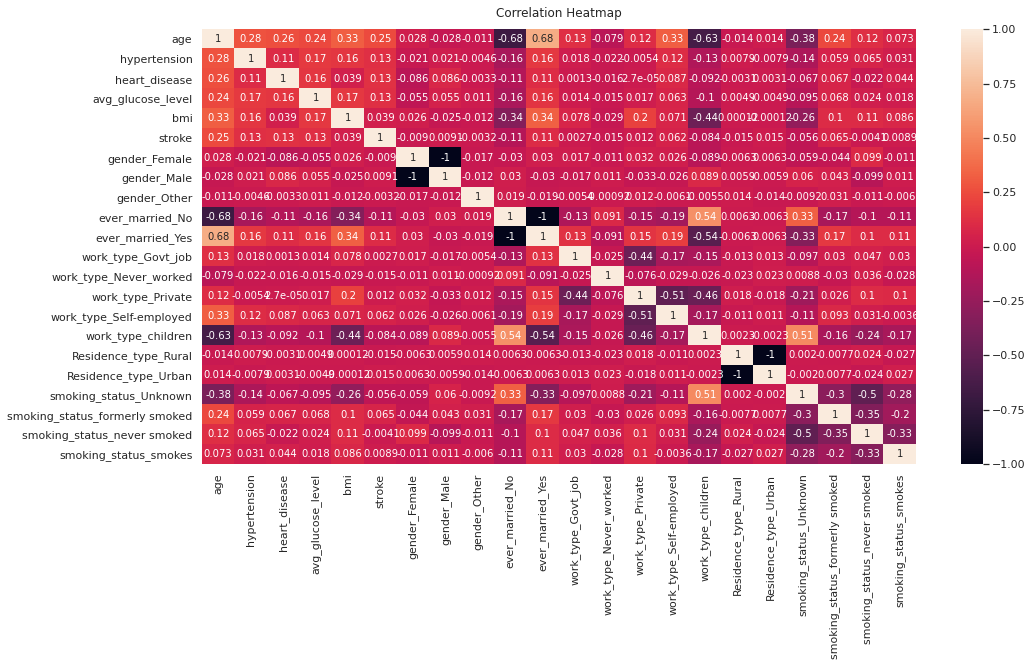

In [181]:
plt.figure(figsize=(16, 8))

heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [182]:
#Decision Tree model is suitable for unbalanced dataset, try it before scaling the data set
x = Stroke_df1.drop("stroke", axis=1)
y = Stroke_df1["stroke"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

DecisionTree_model = DecisionTreeClassifier()
DecisionTree_model.fit(x_train, y_train)

#get the prediction and print the report

predictions = DecisionTree_model.predict(x_test)
print(classification_report(y_test, predictions))
#Get the accuracy score of the DecisionTree model

DecisionTree_accuracy_score = accuracy_score(y_test, predictions)
DecisionTree_accuracy_score

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1453
           1       0.12      0.10      0.11        80

    accuracy                           0.92      1533
   macro avg       0.54      0.53      0.53      1533
weighted avg       0.91      0.92      0.91      1533



0.9158512720156555

Text(89.18, 0.5, 'Pred label')

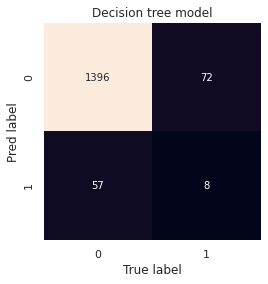

In [183]:
#Sensitivity (True Positive rate) is not very high even using decision tree
confmat = confusion_matrix(y_test, predictions)
plt.title('Decision tree model')
sns.heatmap(confmat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Pred label')

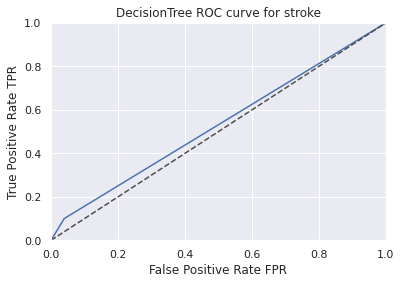

In [184]:
#ROC curve comparing Random Forest with KNN
y_pred_quant_DecisionTree = DecisionTree_model.predict_proba(x_test)[:, 1]
fpr_DecisionTree, tpr_DecisionTree, thresholds_DecisionTree = roc_curve(y_test, y_pred_quant_DecisionTree)

fig, ax = plt.subplots()
ax.plot(fpr_DecisionTree, tpr_DecisionTree)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim((0,1))
plt.ylim((0,1))
plt.rcParams['font.size'] = 10
plt.title('DecisionTree ROC curve for stroke')
plt.xlabel('False Positive Rate FPR')
plt.ylabel('True Positive Rate TPR')
plt.grid(True)

In [185]:
Stroke_df1_train, Stroke_df1_test = train_test_split(Stroke_df1, test_size=0.3, random_state=10)

In [186]:
#Prepare for scaling dataset
Stroke_df1_train_majority = Stroke_df1_train[Stroke_df1_train.stroke==0]
Stroke_df1_train_minority = Stroke_df1_train[Stroke_df1_train.stroke==1]

In [187]:
#downsamle dataset
def downsampling(df):
    df_majority = df[df.stroke==0]
    df_minority = df[df.stroke==1]
    df_downsampled = resample(df, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df[df.stroke==1]),     # to match minority class
                                 random_state=123) # reproducible results
    df_d = pd.concat([df_downsampled, df_minority])
    return df_d

In [188]:
Stroke_df1_d = downsampling(Stroke_df1_train)

In [241]:
#upsamle dataset using SMOTE
sm = SMOTE(random_state = 2) 
x_train_u, y_train_u = sm.fit_resample(x_train, y_train) 

In [190]:
#downsamled RandomForest model

x_train_d = Stroke_df1_d.drop("stroke", axis=1)
y_train_d = Stroke_df1_d["stroke"]

x_test = Stroke_df1_test.drop("stroke", axis=1)
y_test = Stroke_df1_test["stroke"]

RandomForest_model_d = RandomForestClassifier()
RandomForest_model_d.fit(x_train_d, y_train_d)

#get the prediction and print the report

predictions = RandomForest_model_d.predict(x_test)
print(classification_report(y_test, predictions))
#Get the accuracy score of the RandomForest model

RandomForest_downsampled_accuracy_score = accuracy_score(y_test, predictions)
RandomForest_downsampled_accuracy_score

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1453
           1       0.14      0.78      0.24        80

    accuracy                           0.74      1533
   macro avg       0.56      0.76      0.54      1533
weighted avg       0.94      0.74      0.81      1533



0.7377690802348337

In [191]:
cv = KFold(n_splits=5, random_state=10, shuffle=True)

In [192]:
#Cross-Validation score
def cross_val_score_downsampled(model):   
    scores = []
    for train_index, test_index in cv.split(x):
        #print("TRAIN:", train_index, len(train_index), "TEST:", test_index, len(test_index))
        Stroke_df1_train_fold = Stroke_df1.loc(axis=0)[train_index]
        Stroke_df1_test_fold = Stroke_df1.loc(axis=0)[test_index]
        Stroke_df1_fold_d = downsampling(Stroke_df1_train_fold)
        x_train_fold_downsample = Stroke_df1_fold_d.drop("stroke", axis=1)
        y_train_fold_downsample = Stroke_df1_fold_d["stroke"]
        x_val_fold = Stroke_df1_test_fold.drop("stroke", axis=1)
        y_val_fold = Stroke_df1_test_fold["stroke"]
        model_obj = model.fit(x_train_fold_downsample, y_train_fold_downsample)
        score = recall_score(y_val_fold, model_obj.predict(x_val_fold))
        scores.append(score)
    return np.array(scores)

In [193]:
score = cross_val_score_downsampled(RandomForest_model_d)
print(score)
print(score.mean())

[0.72580645 0.83673469 0.82608696 0.78723404 0.84444444]
0.8040613178019658


In [194]:
confmat_downsampled = confusion_matrix(y_test, predictions)

In [244]:
#upsamled RandomForest model
RandomForest_model_u = RandomForestClassifier()
RandomForest_model_u.fit(x_train_u, y_train_u)

#get the prediction and print the report

predictions = RandomForest_model_u.predict(x_test)
print(classification_report(y_test, predictions))
#Get the accuracy score of the RandomForest model

RandomForest_upsamled_accuracy_score = accuracy_score(y_test, predictions)
RandomForest_upsamled_accuracy_score

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1453
           1       0.06      0.01      0.02        80

    accuracy                           0.94      1533
   macro avg       0.51      0.50      0.49      1533
weighted avg       0.90      0.94      0.92      1533



0.9386823222439661

In [196]:
#Cross-Validation score
def cross_val_score_upsampled(model):
    scores = []
    for train_index, test_index in cv.split(x):
        #print("TRAIN:", train_index, len(train_index), "TEST:", test_index, len(test_index))
        x_train_fold, x_val_fold = x.loc(axis=0)[train_index], x.loc(axis=0)[test_index]
        y_train_fold, y_val_fold = y.loc(axis=0)[train_index], y.loc(axis=0)[test_index]
        x_train_fold_upsample, y_train_fold_upsample = sm.fit_resample(x_train_fold, y_train_fold)    
        model_obj = RandomForest_model_u.fit(x_train_fold_upsample, y_train_fold_upsample)
        score = recall_score(y_val_fold, model_obj.predict(x_val_fold))
        scores.append(score)
    return np.array(scores)

In [197]:
score = cross_val_score_upsampled(RandomForest_model_u)
print(score)
print(score.mean())

[0.         0.         0.06521739 0.06382979 0.04444444]
0.034698324596566965


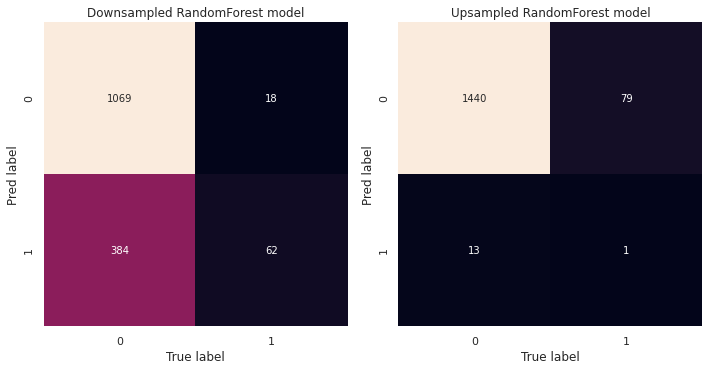

In [206]:
#Compare two model using confusion matrix
confmat_upsampled = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Downsampled RandomForest model')
sns.heatmap(confmat_downsampled.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Pred label')
plt.subplot(1, 2, 2)
plt.title('Upsampled RandomForest model')
sns.heatmap(confmat_upsampled.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Pred label')
plt.tight_layout()
#Downsampling is better, choose downsampling instead

Max score：0.8284979792400385 Number of subtrees：171


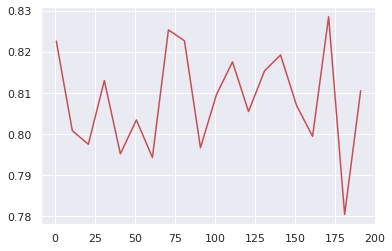

In [129]:
#Optimizing paramter for RandomForest model. no needs to run everytime, take lots of time
score_lt = []

for i in range(0,200,10):
    RandomForest_model = RandomForestClassifier(n_estimators=i+1, random_state=90)
    score = cross_val_score_downsampled(RandomForest_model_d).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('Max score：{}'.format(score_max),
      'Number of subtrees：{}'.format(score_lt.index(score_max)*10+1))

score_x = np.arange(1,201,10)
plt.subplot(111)
plt.plot(score_x, score_lt, 'r-')
plt.show()

Max score：0.8289014410335767 Number of subtrees：176


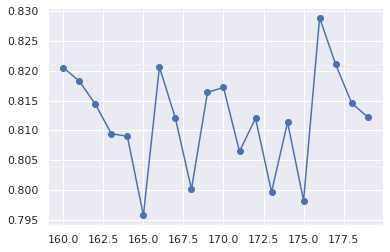

In [131]:
#Smaller steps towards best value
score_lt = []

for i in range(160,180):
    RandomForest_model = RandomForestClassifier(n_estimators=i+1, random_state=90)
    score = cross_val_score_downsampled(RandomForest_model_d).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('Max score：{}'.format(score_max),
      'Number of subtrees：{}'.format(score_lt.index(score_max)+160))

score_x = np.arange(160,180)
plt.subplot(111)
plt.plot(score_x, score_lt, 'o-')
plt.show()

In [268]:
#Optimized upsamled RandomForest model and Cross-Validation score
RandomForest_model_d = RandomForestClassifier(n_estimators=176, random_state=90)
RandomForest_model_d.fit(x_train_d, y_train_d)

predictions = RandomForest_model_d.predict(x_test)

score = cross_val_score_downsampled(RandomForest_model)
print(score)
print(score.mean())

[0.72580645 0.83673469 0.86956522 0.78723404 0.86666667]
0.8172014144203233


In [269]:
#prepare data for plotting ROC curve
y_pred_quant_RandomForest_d = RandomForest_model_d.predict_proba(x_test)[:, 1]

In [270]:
fpr_RandomForest_d, tpr_RandomForest_d, thresholds_RandomForest_d = roc_curve(y_test, y_pred_quant_RandomForest_d)

In [285]:
#downsamled KNN model
knn_model_d = KNeighborsClassifier(n_neighbors=1)
knn_model_d.fit(x_train_d, y_train_d)

#get the prediction and print the report

predictions = knn_model_d.predict(x_test)
print(classification_report(y_test, predictions))
#Get the accuracy score of the KNN model

knn_accuracy_score = accuracy_score(y_test, predictions)
knn_accuracy_score

              precision    recall  f1-score   support

           0       0.97      0.69      0.81      1453
           1       0.10      0.62      0.17        80

    accuracy                           0.69      1533
   macro avg       0.54      0.66      0.49      1533
weighted avg       0.93      0.69      0.78      1533



0.6894977168949772

In [286]:
confmat_d = confusion_matrix(y_test, predictions)

In [288]:
#upsamled KNN model
knn_model_u = KNeighborsClassifier(n_neighbors=1)
knn_model_u.fit(x_train_u, y_train_u)

#get the prediction and print the report

predictions = knn_model_u.predict(x_test)
print(classification_report(y_test, predictions))
#Get the accuracy score of the KNN model

knn_accuracy_score = accuracy_score(y_test, predictions)
knn_accuracy_score

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1453
           1       0.12      0.30      0.17        80

    accuracy                           0.85      1533
   macro avg       0.54      0.59      0.54      1533
weighted avg       0.91      0.85      0.88      1533



0.8486627527723418

best score is:  0.7932159165035877
best k is:  2
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1453
           1       0.12      0.45      0.19        80

    accuracy                           0.79      1533
   macro avg       0.54      0.63      0.53      1533
weighted avg       0.92      0.79      0.85      1533



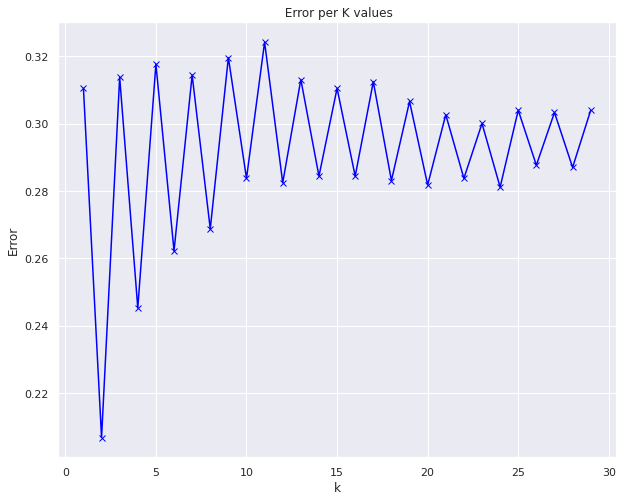

In [290]:
#Try to adjust k values for KNN model
error = []
best_score = 0.0
best_k = 0

for i in range(1,30):
    knn_model_d = KNeighborsClassifier(n_neighbors=i)
    knn_model_d.fit(x_train_d, y_train_d)
    i_predictions = knn_model_d.predict(x_test)
    error.append(np.mean(i_predictions != y_test))
    score = sum(i_predictions == y_test) / len(y_test)
    if score > best_score:
        best_score = score
        best_k = i
    
print("best score is: ", best_score)
print("best k is: ", best_k)
    
#plotting knn errors per k values 
plt.figure(figsize=(10,8))
plt.plot(range(1,30),error,color="blue", marker="x")
plt.title(" Error per K values")
plt.xlabel("k")
plt.ylabel("Error")

#found original value k = 2 is more accurate
#printing the predictions report

knn_model_d = KNeighborsClassifier(n_neighbors=2)
knn_model_d.fit(x_train_d, y_train_d)
predictions = knn_model_d.predict(x_test)

print(classification_report(y_test, predictions))

In [291]:
knn_accuracy_score_iteration = accuracy_score(y_test, predictions)
knn_accuracy_score_iteration

0.7932159165035877

In [292]:
#Cross-Validation score
score = cross_val_score_downsampled(knn_model_d)
print(score)
print(score.mean())

[0.35483871 0.59183673 0.58695652 0.53191489 0.37777778]
0.4886649275010453


best score is:  0.867579908675799
best k is:  2
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1453
           1       0.12      0.24      0.16        80

    accuracy                           0.87      1533
   macro avg       0.54      0.57      0.54      1533
weighted avg       0.91      0.87      0.89      1533



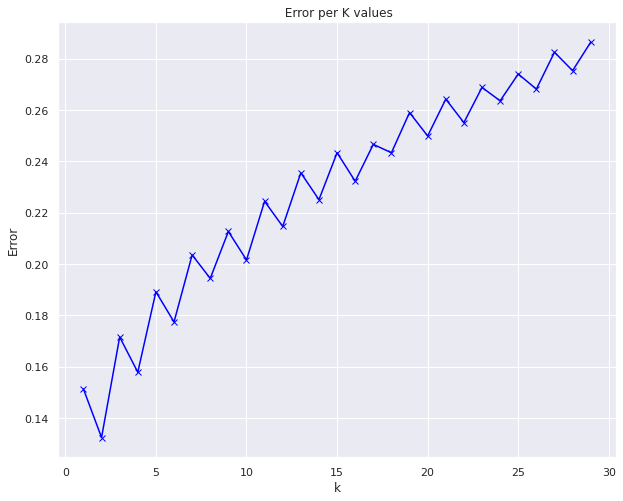

In [293]:
#Try to adjust k values for KNN model
error = []
best_score = 0.0
best_k = 0

for i in range(1,30):
    knn_model_u = KNeighborsClassifier(n_neighbors=i)
    knn_model_u.fit(x_train_u, y_train_u)
    i_predictions = knn_model_u.predict(x_test)
    error.append(np.mean(i_predictions != y_test))
    score = sum(i_predictions == y_test) / len(y_test)
    if score > best_score:
        best_score = score
        best_k = i
    
print("best score is: ", best_score)
print("best k is: ", best_k)
    
#plotting knn errors per k values 
plt.figure(figsize=(10,8))
plt.plot(range(1,30),error,color="blue", marker="x")
plt.title(" Error per K values")
plt.xlabel("k")
plt.ylabel("Error")

#found original value k = 2 is more accurate
#printing the predictions report

knn_model_u = KNeighborsClassifier(n_neighbors=2)
knn_model_u.fit(x_train_u, y_train_u)
predictions = knn_model_u.predict(x_test)

print(classification_report(y_test, predictions))

In [294]:
knn_accuracy_score_iteration = accuracy_score(y_test, predictions)
knn_accuracy_score_iteration

0.867579908675799

In [295]:
#Cross-Validation score(might be wrong, just don't put in it)
score = cross_val_score_upsampled(knn_model_u)
print(score)
print(score.mean())

[0.         0.02040816 0.02173913 0.04255319 0.04444444]
0.025828985926778975


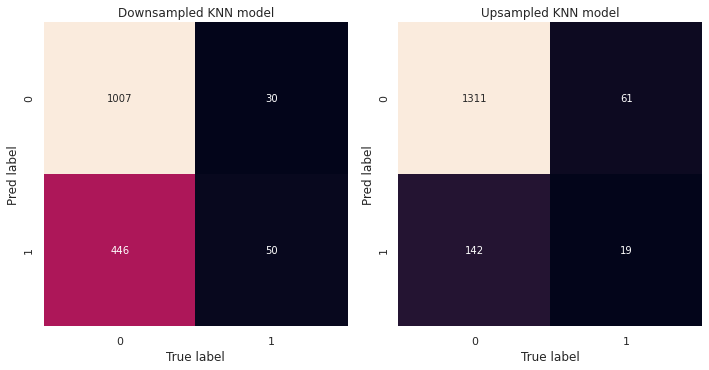

In [296]:
#Compare two model using confusion matrix
confmat_u = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Downsampled KNN model')
sns.heatmap(confmat_d.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Pred label')
plt.subplot(1, 2, 2)
plt.title('Upsampled KNN model')
sns.heatmap(confmat_u.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Pred label')
plt.tight_layout()
#Downsampling is better, choose downsampling instead

In [297]:
y_pred_quant_knn_model = knn_model_d.predict_proba(x_test)[:, 1]

In [298]:
fpr_knn_model, tpr_knn_model, thresholds_knn_model = roc_curve(y_test, y_pred_quant_knn_model)

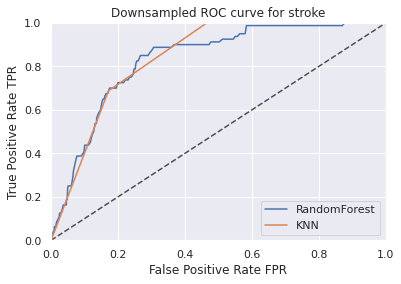

In [299]:
#ROC curve comparing Random Forest with KNN
fig, ax = plt.subplots()
ax.plot(fpr_RandomForest_d, tpr_RandomForest_d)
ax.plot(fpr_knn_model, tpr_knn_model)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim((0,1))
plt.ylim((0,1))
plt.rcParams['font.size'] = 10
plt.legend(labels=["RandomForest","KNN"])
plt.title('Downsampled ROC curve for stroke')
plt.xlabel('False Positive Rate FPR')
plt.ylabel('True Positive Rate TPR')
plt.grid(True)

In [227]:
#prepare for visualizing original dataset 
Stroke_df2 = Stroke_df[(Stroke_df['stroke'] == 1)]

In [228]:
Stroke_df3 = Stroke_df[(Stroke_df['stroke'] == 0)]

Text(0.5, 1.0, 'Age distribution for people who have stroke')

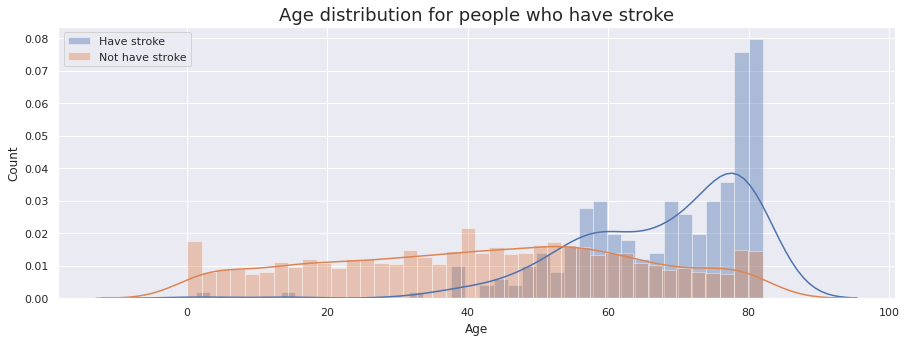

In [38]:
plt.figure(figsize=(15,5))
age_dist = sns.distplot(Stroke_df2.age, bins= 40)
age_dist = sns.distplot(Stroke_df3.age, bins= 40)
age_dist.set(xlabel='Age',ylabel='Count')
age_dist.legend(labels=["Have stroke","Not have stroke"])
plt.title('Age distribution for people who have stroke', fontsize=18)

Text(0.5, 1.0, 'Avg glucose level distribution for people who have stroke')

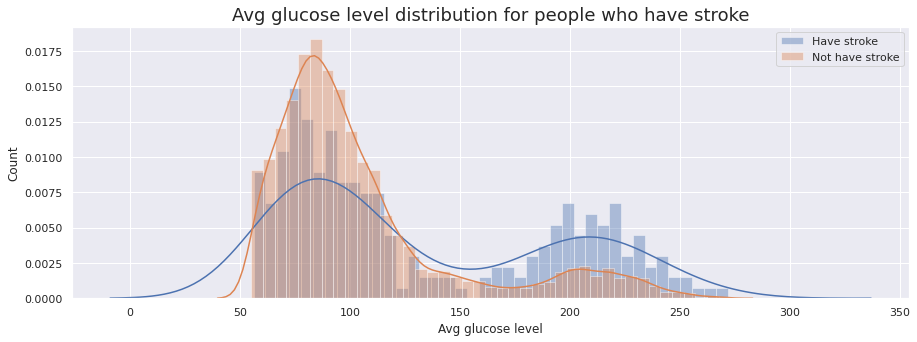

In [39]:
plt.figure(figsize=(15,5))
glucose_dist = sns.distplot(Stroke_df2.avg_glucose_level, bins= 40)
glucose_dist = sns.distplot(Stroke_df3.avg_glucose_level, bins= 40)
glucose_dist.set(xlabel='Avg glucose level',ylabel='Count')
glucose_dist.legend(labels=["Have stroke","Not have stroke"])
plt.title('Avg glucose level distribution for people who have stroke', fontsize=18)

Text(0.5, 1.0, 'BMI level distribution for people who have stroke')

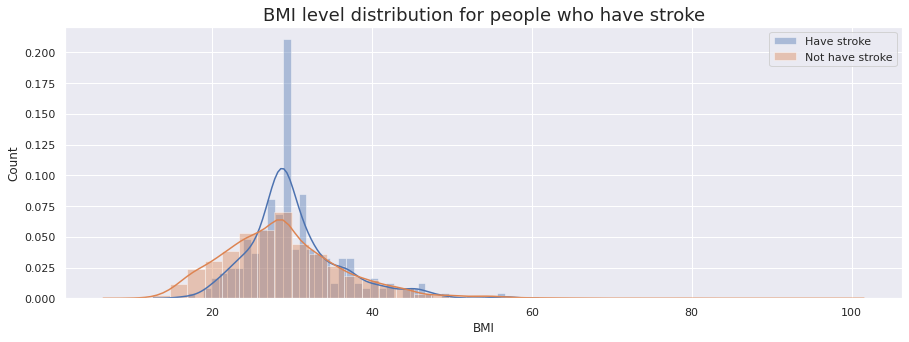

In [40]:
plt.figure(figsize=(15,5))
bmi_dist = sns.distplot(Stroke_df2.bmi, bins= 40)
bmi_dist = sns.distplot(Stroke_df3.bmi, bins= 40)
bmi_dist.set(xlabel='BMI',ylabel='Count')
bmi_dist.legend(labels=["Have stroke","Not have stroke"])
plt.title('BMI level distribution for people who have stroke', fontsize=18)

In [41]:
def sex_count(a):
    male_count, female_count = 0, 0
    for row in a.index:
        if a['gender'][row] == 'Male':
            male_count+=1
        elif a['gender'][row] == 'Female':
            female_count+=1
    return male_count, female_count

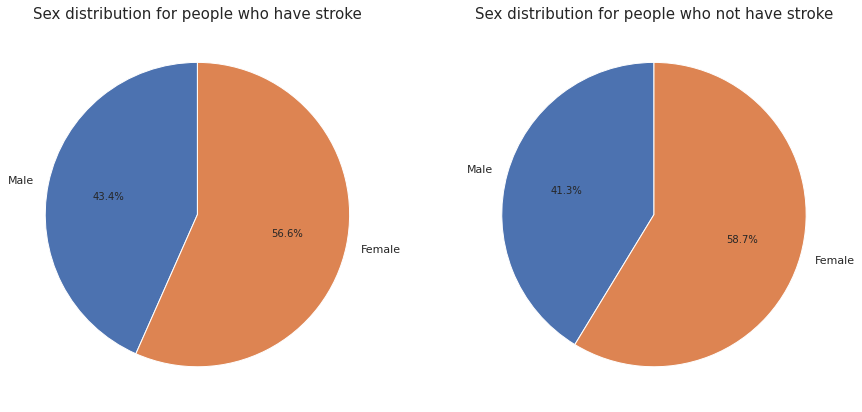

In [42]:
sex_labels = ['Male', 'Female']
sex = list(sex_count(Stroke_df2))
sex1 = list(sex_count(Stroke_df3))
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.title('Sex distribution for people who have stroke', fontsize=15)
plt.pie(sex, labels=sex_labels, autopct='%1.1f%%', startangle=90)
plt.subplot(1, 2, 2)
plt.title('Sex distribution for people who not have stroke', fontsize=15)
plt.pie(sex1, labels=sex_labels, autopct='%1.1f%%', startangle=90)
plt.show()

In [43]:
def heart_disease_count(a):
    heart_disease_count, no_heart_disease_count = 0, 0
    for row in a.index:
        if a['heart_disease'][row] == 1:
            heart_disease_count+=1
        elif a['heart_disease'][row] == 0:
            no_heart_disease_count+=1
    return heart_disease_count, no_heart_disease_count

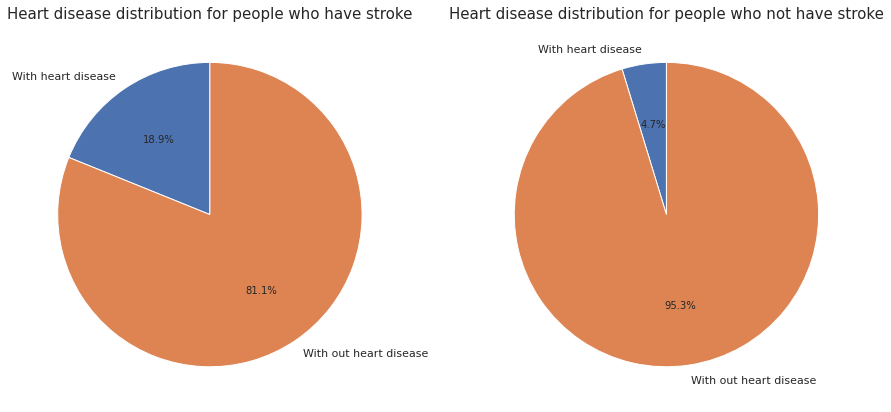

In [44]:
heart_disease_labels = ['With heart disease', 'With out heart disease']
heart_disease = list(heart_disease_count(Stroke_df2))
heart_disease1 = list(heart_disease_count(Stroke_df3))
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.title('Heart disease distribution for people who have stroke', fontsize=15)
plt.pie(heart_disease, labels=heart_disease_labels, autopct='%1.1f%%', startangle=90)
plt.subplot(1, 2, 2)
plt.title('Heart disease distribution for people who not have stroke', fontsize=15)
plt.pie(heart_disease1, labels=heart_disease_labels, autopct='%1.1f%%', startangle=90)
plt.show()

In [45]:
def hypertension_count(a):
    hypertension_count, no_hypertension_count = 0, 0
    for row in a.index:
        if a['hypertension'][row] == 1:
            hypertension_count+=1
        elif a['hypertension'][row] == 0:
            no_hypertension_count+=1
    return hypertension_count, no_hypertension_count

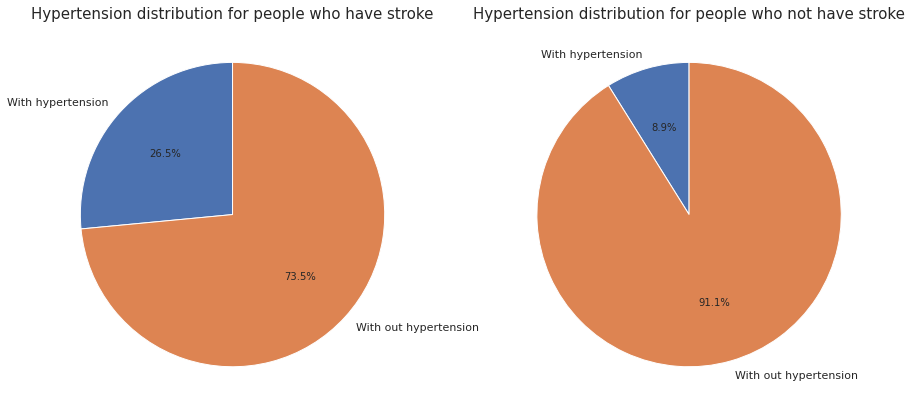

In [46]:
hypertension_labels = ['With hypertension', 'With out hypertension']
hypertension = list(hypertension_count(Stroke_df2))
hypertension1 = list(hypertension_count(Stroke_df3))
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.title('Hypertension distribution for people who have stroke', fontsize=15)
plt.pie(hypertension, labels=hypertension_labels, autopct='%1.1f%%', startangle=90)
plt.subplot(1, 2, 2)
plt.title('Hypertension distribution for people who not have stroke', fontsize=15)
plt.pie(hypertension1, labels=hypertension_labels, autopct='%1.1f%%', startangle=90)
plt.show()

In [47]:
def smokes_count(a):
    smokes_count, formerly_smoked_count, never_smoked_count, Unknown_count = 0, 0, 0, 0
    for row in a.index:
        if a['smoking_status'][row] == 'smokes':
            smokes_count+=1
        elif a['smoking_status'][row] == 'formerly smoked':
            formerly_smoked_count+=1
        elif a['smoking_status'][row] == 'never smoked':
            never_smoked_count+=1
        elif a['smoking_status'][row] == 'Unknown':
            Unknown_count+=1
    return smokes_count, formerly_smoked_count, never_smoked_count, Unknown_count

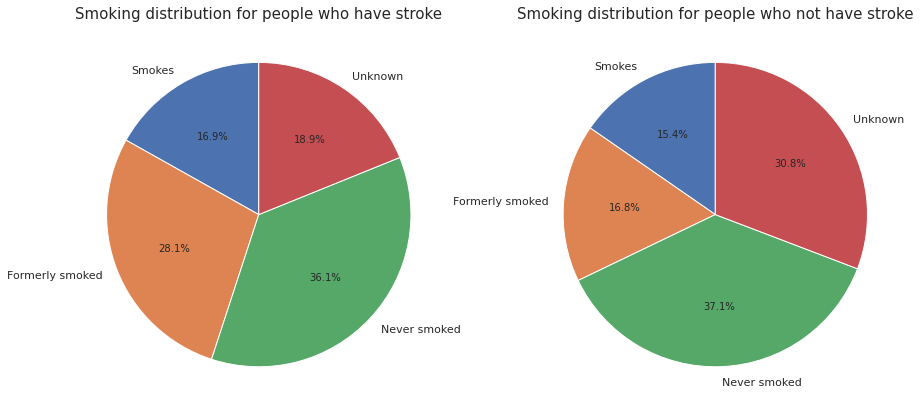

In [48]:
smokes_labels = ['Smokes', 'Formerly smoked', 'Never smoked', 'Unknown']
smokes = list(smokes_count(Stroke_df2))
smokes1 = list(smokes_count(Stroke_df3))
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.title('Smoking distribution for people who have stroke', fontsize=15)
plt.pie(smokes, labels=smokes_labels, autopct='%1.1f%%', startangle=90)
plt.subplot(1, 2, 2)
plt.title('Smoking distribution for people who not have stroke', fontsize=15)
plt.pie(smokes1, labels=smokes_labels, autopct='%1.1f%%', startangle=90)
plt.show()

Text(0.5, 1.0, 'Smoking status age distribution')

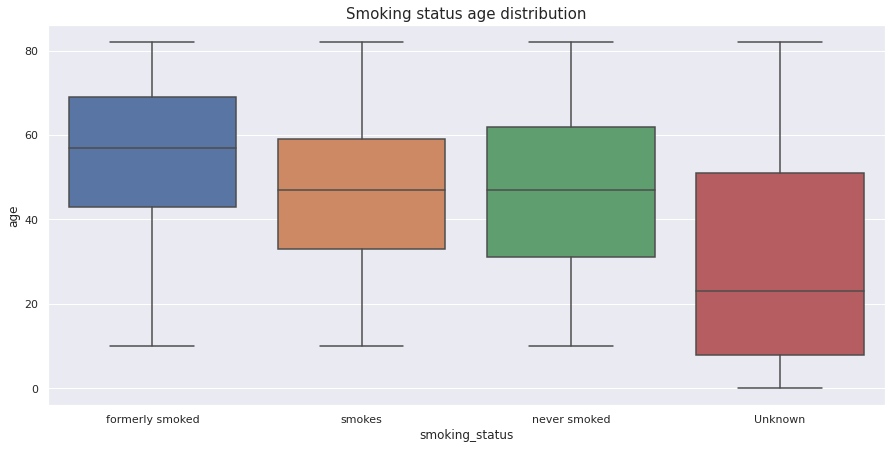

In [234]:
#Box Plot
plt.figure(figsize=(15,7))
sns.boxplot(x='smoking_status', y='age', data=Stroke_df, order=['formerly smoked','smokes','never smoked','Unknown'])
plt.title('Smoking status age distribution', fontsize=15)